In [1]:
# imports
%matplotlib inline
import seaborn as sns
from pyrt.data.data_trots import *
from pyrt.optimization.vmat import *
from pyrt.tools import *


In [2]:
# Troy Inputs - Prostate
# Find work directory
# cwd = '/Users/troy/Dropbox/CAP Group/TROTS/Prostate_VMAT/'
working_directory = 't-roy/'
cwd = '/media/troy/DataDrive/Dropbox/CAP Group/TROTS/Prostate_VMAT/'

# Load patient information
filename = 'Prostate_VMAT_101.mat'

imrt_model_params = {
    'target_weights':{'PTV':1000., 'default':500.},
    'oar_weights':{'Rectum':10., 'Bladder':10., 'default':1.},
    'min_intensity':0,
    'max_intensity':1000
}


input_dict = {
    'cwd': cwd,
    'figure_directory':working_directory,
    'filename': filename,
    'Rx': {'PTV': 79.56, 'PTV Vesicles': 72.2},
    'model_params':imrt_model_params
}



In [ ]:
# # Troy Inputs - H&N
# # Find work directory
# # cwd = '/Users/troy/Dropbox/CAP Group/TROTS/Prostate_VMAT/'
# working_directory = 'outputs_troy/'
# cwd = '/media/troy/DataDrive/Dropbox/CAP Group/TROTS/Prostate_VMAT/'

# # Load patient information
# filename = 'Prostate_VMAT_101.mat'

# imrt_model_params = {
#     'target_weights':{'PTV':1000., 'default':500.},
#     'oar_weights':{'Rectum':10., 'Bladder':10., 'default':1.}
# }


# input_dict = {
#     'cwd': cwd,
#     'figure_directory':working_directory,
#     'filename': filename,
#     'Rx': {'PTV': 79.56, 'PTV Vesicles': 72.2},
#     'model_params':imrt_model_params
# }

In [ ]:
model = vmat_mip(input_dict)

In [3]:
model = conformal_arc(input_dict)

---------------------
|  Reading in data  |
---------------------
Building Structures
importing PTV Dij as dense matrix, converting to sparse...
importing PTV Shell 50 mm Dij as dense matrix, converting to sparse...
importing External Ring 20 mm Dij as sparse matrix
importing PTV Shell 5 mm Dij as dense matrix, converting to sparse...
importing PTV Shell 15 mm Dij as dense matrix, converting to sparse...
importing PTV Shell 25 mm Dij as dense matrix, converting to sparse...
importing Rectum Dij as dense matrix, converting to sparse...
importing Anus Dij as dense matrix, converting to sparse...
importing Hip (L) Dij as dense matrix, converting to sparse...
importing Hip (R) Dij as dense matrix, converting to sparse...
importing Bladder Dij as dense matrix, converting to sparse...
importing Patient Dij as dense matrix, converting to sparse...
Building CP
----------------------------
|  Data reading completed  |
----------------------------


In [ ]:
a,b = model.calc_obj_grad(np.ones(model.num_apers))
print model.num_apers
print a
print type(b)

In [4]:
model.optimize(display=5,UB=1000.)


Solver Starting...
conf_arc model solved in 0.179250955582 seconds


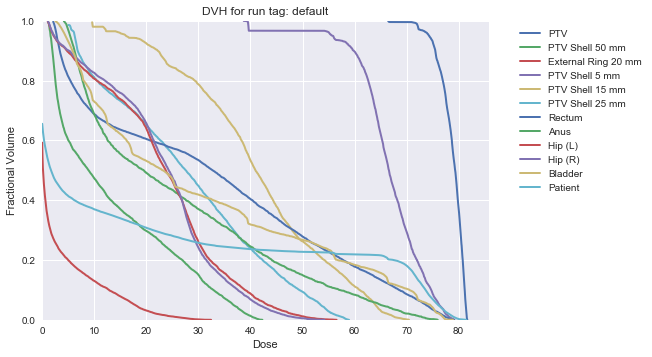

In [5]:
model.plot_DVH(run_tag='default',saveDVH=True)

In [ ]:
model.aper_intensities

In [ ]:
model.calc_dose_from_variables(x=np.ones(model.num_apers))
model.save_current_dose(run_tag='ones')
model.plot_DVH(run_tag='ones',saveDVH=True)
# model.calc_dose_from_variables(x=2*np.ones(model.num_apers))
# model.save_current_dose(run_tag='twos')
# model.plot_DVH(run_tag='twos',saveDVH=True)

In [ ]:
s = 1
beamlet_members = [1,2,3,4]
Dkj_per_structure = [np.zeros(s_t.num_vox) for s_t in model.data.structures]
Dkj_per_structure[s] = np.asarray(model.data.structures[s].Dij[np.array(beamlet_members)].sum(axis=0)).flatten()
print Dkj_per_structure[1].shape

In [ ]:
cp0 = model.data.control_points[0]
assert(isinstance(cp0,control_point))
for r in range(cp0.num_rows):
    print cp0.field[cp0.min_row+r][cp0.left_leaf_position[r]:cp0.left_leaf_position[r]+cp0.num_beamlets_in_row[r]]

In [ ]:
model.data.structures[0].Dij[5,:].todense()
indices = np.array([1,2])
a = np.asarray(model.data.structures[0].Dij[indices].sum(axis=0))

b = (model.data.structures[0].Dij[1,:] + model.data.structures[0].Dij[2,:]).transpose().todense()

print a.flatten()
print b.flatten()
a[0]

In [ ]:


a = aperture(model.data, model.data.control_points[0],set_open_aper=True)

assert(isinstance(a,aperture))

print a.left_leaf_position
print a.right_leaf_position
print a.intensity
for s in range(len(model.data.structures)) :
    print a.Dkj_per_structure[s].shape, a.Dkj_per_structure[s].max()


In [ ]:
target_mask = [np.zeros(model.data.structures[s].num_vox) for s in range(len(model.data.structures))]
for s in range(len(model.data.structures)):
    if model.data.structures[s].is_target:
        target_mask[s] = 10.*np.ones(model.data.structures[s].num_vox)/model.data.structures[s].num_vox
    else:
        target_mask[s] = -1.*np.ones(model.data.structures[s].num_vox)/model.data.structures[s].num_vox
        
beamlet_usefulness = np.zeros(model.data.num_beamlets)

for s in range(len(model.data.structures)):
    beamlet_usefulness+= model.data.structures[s].Dij.dot(target_mask[s])
    
    
beamlet_usefulness
        
sns.distplot(beamlet_usefulness, hist=False, color="g", kde_kws={"shade": True})



In [ ]:
def plot_aper(aper, data, aper_number, tight_bool=False,save_bool=False, save_name='aper_', buffer=1):
    relevant_beamlets = np.array(aper.beamlet_members[:]) - data.control_points[aper.cp_number].initial_beamlet_index
    fluence_map = np.zeros(data.control_points[aper.cp_number].field.shape)
    for r in relevant_beamlets:
        x,y = tuple(data.control_points[aper.cp_number].field_position[r,:])
        fluence_map[x,y] = 1.
    plt.figure()
    
    if tight_bool:
        rmin,rmax,cmin,cmax = bounding_box(fluence_map, buffer=buffer)
        sns.heatmap(fluence_map[rmin:rmax,cmin:cmax])
    else:        
        sns.heatmap(fluence_map)
    
    if save_bool:
        if not os.path.exists(data.input_dict['cwd'] + data.input_dict['figure_directory']):
            os.makedirs(data.input_dict['cwd'] + data.input_dict['figure_directory'])
    
        plt.savefig(data.input_dict['cwd'] + data.input_dict['figure_directory'] + save_name + '_' + str(aper_number) + '.png',
                    bbox_inches='tight')
    
    

pyrt/tools.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  fluence_map[x, y] = 1.


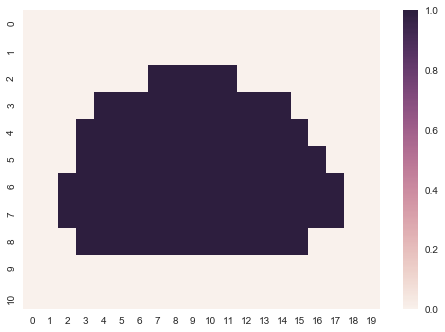

In [6]:
a = aperture(model.data, model.data.control_points[1],set_open_aper=True)
plot_aper(a,model.data,1,save_bool=True,tight_bool=True, buffer = 2)

In [ ]:
index = 0
a = aperture(model.data, model.data.control_points[index],set_open_aper=True)

relevant_beamlets = a.beamlet_members[:]

fluence_map = np.zeros(model.data.control_points[index].field.shape)
for r in relevant_beamlets:
    x,y = tuple(model.data.control_points[index].field_position[r,:])
    fluence_map[x,y] = 1.
    
print fluence_map

sns.heatmap(fluence_map)






